# Nederlands-Fries

- https://leren.windesheim.nl/d2l/le/lessons/103162/topics/927096

## 1. Business Understanding

Vertaal Nederlandse zinnen naar het Fries.

## 2. Data Understanding

School heeft ons al de code aangeleverd die een tekstcorpus van het Fryske Akademy downloadt, alsook deze gegevens omgezet naar een CSV-bestand.

### 2.1. Bibliotheken importeren

In [1]:
!pip install keras_nlp


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import re
import keras
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_nlp
import matplotlib.pyplot as plt

from keras import layers
from sklearn.model_selection import train_test_split

2024-10-13 11:27:19.391983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 11:27:19.407004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 11:27:19.410598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 11:27:19.421376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
if "NederlandsFries.ipynb" not in os.listdir('.'):
    os.chdir("Thema 3")

### 2.2. Inlezen `dataset.csv`
De corpus bevat twee simpele kolommen, een met de Nederlandse tekst, en een met de Friese vertaling.

In [4]:
dataset_df = pd.read_csv("Data/dataset.csv")
dataset_df.info()
dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   nederlands  173912 non-null  object
 1   fries       173912 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


,nederlands,fries
0,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
1,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
2,een plotselinge dood,in hastige dea
3,een plotselinge dood,in unferwachte dea
4,zijn plotseling overlijden,syn hastich ferstjerren


### 2.3. Inzicht zinlengte
We zien dat de teksten maximaal 60 woorden bevatten, en gemiddeld 9 woorden. Gelukkig niet te veel, zo kunnen we hem makkelijker trainen.

In [5]:
hoeveelheid_woorden_nederlands = dataset_df['nederlands'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_nederlands.min()} Max {hoeveelheid_woorden_nederlands.max()} gemiddeld {hoeveelheid_woorden_nederlands.mean()}")

Min 1 Max 59 gemiddeld 9.066044896269378


In [6]:
hoeveelheid_woorden_fries = dataset_df['fries'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_fries.min()} Max {hoeveelheid_woorden_fries.max()} gemiddeld {hoeveelheid_woorden_fries.mean()}")

Min 1 Max 60 gemiddeld 9.237137172823036


### 2.4. Inzicht woordhoeveelheid

In [7]:
len(np.unique(np.hstack(dataset_df['nederlands'].apply(lambda txt: np.array(txt.split())))))

70245

In [8]:
len(np.unique(np.hstack(dataset_df['fries'].apply(lambda txt: np.array(txt.split())))))

74319

## 3. Data Preparation

Tekst

## 3.1. Start en eindtokens toevoegen

In [9]:
START_TOKEN = "[begin]"
END_TOKEN = "[einde]"

def omringMetBeginEnEinde(tekst):
    return f"{START_TOKEN} {tekst} {END_TOKEN}"

dataset_df['fries'] = dataset_df['fries'].apply(omringMetBeginEnEinde)

### 3.1. Splitsen tussen traindata testdata

In [10]:
# train_dutch, test_dutch, train_frisian, test_frisian = train_test_split(
#     dataset_df['nederlands'], dataset_df['fries'],
#     test_size=0.2,
#     shuffle = True,
# )

train_pairs, test_pairs = train_test_split(
    dataset_df,
    test_size=0.2,
    shuffle = True,
)

train_pairs.head()

,nederlands,fries
121580,dat het grote portret verloren is gegaan blijf...,[begin] dat it grutte portret teloar gien is b...
125517,in het nest zaten nog drie ouderafhankelijke j...,[begin] yn it nest sieten noch trije alderofhi...
96212,twee bij vijf drie bij vier centimeter,[begin] trije by fjouwer twa by fjouwer sintim...
54420,samenwerken bij,[begin] oparbeidzje by [einde]
62721,op die vrijdagmorgen,[begin] op de freedtemoarn [einde]


### 3.2. Tekstvectorisatie

In [11]:
dutch_vocab_size   = 20000
frisian_vocab_size = 20000

dutch_maxlen   = 20
frisian_maxlen = 20

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


In [12]:


dutch_text_vectorization = layers.TextVectorization(
    max_tokens=dutch_vocab_size,
    output_mode="int",
    output_sequence_length=dutch_maxlen,
)
dutch_text_vectorization.adapt(dataset_df['nederlands'])

I0000 00:00:1728818845.540632   35572 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728818845.556282   35572 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728818845.556326   35572 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728818845.557753   35572 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728818845.557784   35572 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [13]:
frisian_text_vectorization = layers.TextVectorization(
    max_tokens=frisian_vocab_size,
    output_mode="int",
    output_sequence_length=frisian_maxlen + 1, # <--- om ervoor te zorgen dat hij de volgende gaat voorspellen
    standardize=custom_standardization,
)
frisian_text_vectorization.adapt(dataset_df['fries'])

### 3.2. Dataset

In [14]:
batch_size = 64

def format_dataset(dutch, frisian):
    dutch = dutch_text_vectorization(dutch)
    frisian = frisian_text_vectorization(frisian)

    return ({
        "dutch": dutch,
        "frisian": frisian[:, :-1],
    }, frisian[:, 1:])

def make_dataset(pairs):
    dutch_texts = pairs['nederlands']
    frisian_texts = pairs['fries']
    dutch_texts = list(dutch_texts)
    frisian_texts = list(frisian_texts)
    dataset = tf.data.Dataset.from_tensor_slices((dutch_texts, frisian_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=16)
    return dataset.shuffle(2048).prefetch(16).cache() #in memory caching ivm performance

train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [15]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['dutch'].shape: {inputs['dutch'].shape}")
    print(f"inputs['frisian'].shape: {inputs['frisian'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['dutch'].shape: (64, 20)
inputs['frisian'].shape: (64, 20)
targets.shape: (64, 20)


2024-10-13 11:27:27.571485: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-13 11:27:27.573666: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
for x in train_ds.take(1):
    print(x)

({'dutch': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  254,  3237,    19, ...,     0,     0,     0],
       [    2, 10077,     5, ...,     0,     0,     0],
       [   24,     2,  2034, ...,     0,     0,     0],
       ...,
       [   26,    22,   575, ...,     0,     0,     0],
       [   23,    50,  3496, ...,     1,     7,     2],
       [   20,    38,  1486, ...,     0,     0,     0]])>, 'frisian': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[    3,   241,  3723, ...,     0,     0,     0],
       [    3,     4, 10261, ...,     0,     0,     0],
       [    3,    18,     4, ...,     0,     0,     0],
       ...,
       [    3,    26,    45, ...,     0,     0,     0],
       [    3,    20,     7, ..., 16843,    25,    13],
       [    3,    19,    44, ...,     0,     0,     0]])>}, <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  241,  3723,    22, ...,     0,     0,     0],
       [    4, 10261,     7, ...,     0,     0,     0],
       [   18,     

2024-10-13 11:27:27.809272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-13 11:27:27.811237: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# train_dutch   = tf.data.Dataset.from_tensor_slices(tf.cast(train_dutch.values, tf.string)).batch(64)
# test_dutch    = tf.data.Dataset.from_tensor_slices(tf.cast(test_dutch.values, tf.string)).batch(64)
# train_frisian = tf.data.Dataset.from_tensor_slices(tf.cast(train_frisian.values, tf.string)).batch(64)
# test_frisian  = tf.data.Dataset.from_tensor_slices(tf.cast(test_frisian.values, tf.string)).batch(64)

In [18]:
# print([x for x in train_dutch.take(1)][0][0])
# print([x for x in train_frisian.take(1)][0][0])

In [19]:
# train_ds = tf.data.Dataset.zip((train_dutch,train_frisian))
# test_ds = tf.data.Dataset.zip((test_dutch,test_frisian))

In [20]:
# int_train_ds = train_ds.map(
#     lambda x, y: (dutch_text_vectorization(x), frisian_text_vectorization(y)),
#     num_parallel_calls=16)

# int_test_ds = test_ds.map(
#     lambda x, y: (dutch_text_vectorization(x), frisian_text_vectorization(y)),
#     num_parallel_calls=16)

# print(np.array([x for x in int_train_ds.take(1)]).shape)
# print(int_train_ds)
# # print([x for x in int_test_ds.take(1)][0][0])

## 4. Modeling

Tekst

In [21]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        # Initialize the embeddings for tokens and positions
        self.token_embeddings = layers.Embedding(           # regular embedding
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(        # position embedding
            input_dim=sequence_length, output_dim=output_dim)
        # Some relevant settings for subsequent layers
        # Definnig the settings as part of the object (self.) makes it
        # easier to apply them consistently in the call() method
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]                               # Length of the input sentences
        positions = tf.range(start=0, limit=length, delta=1)        # 0-indexed positions of tokens in the sequences
        # Generate the actual position embeddings
        embedded_tokens = self.token_embeddings(inputs)             # Regular embeddings of the tokens
        embedded_positions = self.position_embeddings(positions)    # Position embeddings
        # We maken hier een 2e embeddingspace voor de positie die we daarna bij het origineel optellen
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0) #geneer mask basis van waar de input niet 0 is.Zodat we de input niet hoeven te padden

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [22]:
class TransformerEncoder(layers.Layer):                              # Our transformer encoder layer inherits from keras.layers.Layer
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):   # the constructor of our encoder layer
        super().__init__(**kwargs)                                   # calls the constructor of the parent class (keras.layers.Layer)

        # Store a whole bunch settings and initialise the building blocks for our encoder layer
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-head attention building block
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # Dense building block
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        # Layer normalisation building block, 1 and 2 are used to normalise the output of the attention and dense blocks respectively
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Here we actually build the encoder layer

        # If we define a mask for attention, we need to perform some preprocessing on it
        if mask is not None:
            mask = mask[:, tf.newaxis, :] #padding mask (negeer alle paffing) voeg een dimensie toe. Transformer verwacht 3D of meer. Embedding layer genereerd 2d layer

        # Define the attention part of the encoder
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        # Apply layer normalisation to the attention output
        proj_input = self.layernorm_1(inputs + attention_output)
        # Apply the dense part of the encoder
        proj_output = self.dense_proj(proj_input)
        # Apply layer normalisation to the dense output, and return the encoder
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        # Return all the configuration settings for this layer

        # Get the configuration settings from the parent class
        config = super().get_config()
        # Add the config settings of our own layer
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [23]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True #anders geen masking mogelijk

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        #prevents the model from learning to copy the next token from the input to the output by hiden it
        # [[1,0,0],
        #  [1,1,0],
        #  [1,1,1]]
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        #Replicate it along the batch axis to get an matrix of shape (batch_size, sequence_length, sequence_length)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        #retrieve the casual mask
        padding_mask = None
        if mask is not None: #prepare the input mask that describes padding locations in the target_sequence
            padding_mask = keras.cast(
                mask[:, tf.newaxis, :], dtype="int32") #extra dim aangezien transfo deze verwacht
            padding_mask = keras.minimum(padding_mask, causal_mask)#merge both masks (input padding en volgende woord padding)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)# pass the casual mask tot the first attention layer, which performs self attention over the target sequence
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, #pass the combined mask to the second attention layer, which relates the source sequence to the target sequence
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [24]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

ter [ts](/usr/local/lib/python3.11/dist-packages/keras_nlp/src/layers/modeling/transformer_encoder.py)

Wow, ziet er veelbelovend uit! Nu snel maar eens een aantal extra keer bijtrainen:

### 4.x Meer params

### 4.x. Lagere dropout
Gezien overfitting geen probleem is op het moment, probeer ik hem te verlagen.

### 4.x. 

## ZONDAG

## MASKED LOSS

In [25]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


## Beter

In [26]:
embed_dim = 128
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

# encoder_embedding = TokenAndPositionEmbedding(dutch_vocab_size, dutch_maxlen, embed_dim)(encoder_inputs)
encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)


# decoder_embedding = TokenAndPositionEmbedding(frisian_vocab_size, frisian_maxlen, embed_dim)(decoder_inputs)
decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_outputs' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dutch (InputLayer)  │ (None, 20)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frisian             │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 20, 128)   │  2,562,560 │ dutch[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ dutch[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 20, 128)   │  2,562,560 │ frisian[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_outputs     │ (None, 20, 128)   │    791,296 │ encoder_embeddin… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 20, 128)   │  1,319,040 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_outputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 20, 128)   │          0 │ decoder[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 20, 20000) │  2,580,000 │ decoder_dropout[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,815,456 (37.44 MB)

 Trainable params: 9,815,456 (37.44 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ke

   1/2174 ━━━━━━━━━━━━━━━━━━━━ 9:26:33 16s/step - loss: 9.9163 - masked_accuracy: 0.0000e+00

I0000 00:00:1728818864.295554   35696 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2078/2174 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.3588 - masked_accuracy: 0.1483

W0000 00:00:1728818889.558124   35693 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-13 11:28:10.299962: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 4 bytes spill stores, 4 bytes spill loads

2024-10-13 11:28:11.098543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 12 bytes spill stores, 12 bytes spill loads

2024-10-13 11:28:11.154019: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 16 bytes spill stores, 16 bytes spill loads

2024-10-13 11:28:11.162926: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] p

2170/2174 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.2924 - masked_accuracy: 0.1539

W0000 00:00:1728818901.220894   35693 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1728818904.011991   35693 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-13 11:28:24.334875: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 4 bytes spill stores, 4 bytes spill loads

2024-10-13 11:28:25.357309: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 192 bytes spill stores, 164 bytes spill loads

2024-10-13 11:28:25.428822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are 

2174/2174 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - loss: 7.2888 - masked_accuracy: 0.1542 - val_loss: 3.8055 - val_masked_accuracy: 0.5009
Epoch 2/3
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 3.7648 - masked_accuracy: 0.5181 - val_loss: 2.7605 - val_masked_accuracy: 0.6316
Epoch 3/3
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 2.7744 - masked_accuracy: 0.6320 - val_loss: 2.3537 - val_masked_accuracy: 0.6816


In [32]:
#nog even testen
import numpy as np
import random
fy_vocab = frisian_text_vectorization.get_vocabulary()
fy_index_lookup = dict(zip(range(len(fy_vocab)), fy_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = dutch_text_vectorization([input_sentence])
    decoded_sentence = START_TOKEN
    indices = []

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence: tf.Tensor = frisian_text_vectorization([decoded_sentence])
        tokenized_target_sentence = tokenized_target_sentence[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        # Pak altijd de laatste voorspelling
        sampled_token_index = np.argmax(predictions[0, i, :])
        indices.append(sampled_token_index)

        sampled_token = fy_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == END_TOKEN:
            break

    return decoded_sentence

test_dutch_texts = [pair[0] for pair in test_pairs.values]
for _ in range(5):
    input_sentence = random.choice(test_dutch_texts)
    print("-----------------------------------------------------------")
    print("NL:", input_sentence)
    print("FY:", decode_sequence(input_sentence))


-----------------------------------------------------------
NL: ik kan wel zingen maar tekstschrijven dat is eigenlijk niet zozeer mijn ding
FY: [begin] ik kin wol sjongen mar it is eins net echt dat is dat is [einde]
-----------------------------------------------------------
NL: was ik er maar nooit aan begonnen dacht ik al snel levensgevaarlijk zon onlinediscussie
FY: [begin] wie ik der mar nea oan begun tocht ik al gau [UNK] [einde]
-----------------------------------------------------------
NL: vooral door kennis van de markt ontstaan kansen en kunnen kansen worden uitgebuit om onderhoudsbaggerwerk zo efficient mogelijk uit te voeren
FY: [begin] foaral troch kennis fan e merk untstean kansen en kinne kansen en kinne derom [UNK] om [UNK] sa hiel te
-----------------------------------------------------------
NL: als kind al werd de levertraan bestreden met sinaasappel zo bestrijd je vervelende zaken met een roze bril
FY: [begin] as bern al waard de [UNK] [UNK] mei [UNK] mei [UNK] dy

In [33]:
embed_dim = 128
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

# encoder_embedding = TokenAndPositionEmbedding(dutch_vocab_size, dutch_maxlen, embed_dim)(encoder_inputs)
encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)


# decoder_embedding = TokenAndPositionEmbedding(frisian_vocab_size, frisian_maxlen, embed_dim)(decoder_inputs)
decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = model.fit(train_ds, epochs=30, validation_data=test_ds)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dutch (InputLayer)  │ (None, 20)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frisian             │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 20, 128)   │  2,562,560 │ dutch[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 20)        │          0 │ dutch[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 20, 128)   │  2,562,560 │ frisian[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_outputs     │ (None, 20, 128)   │    791,296 │ encoder_embeddin… │
│ (TransformerEncode… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 20, 128)   │  1,319,040 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_outputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 20, 128)   │          0 │ decoder[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 20, 20000) │  2,580,000 │ decoder_dropout[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,815,456 (37.44 MB)

 Trainable params: 9,815,456 (37.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1728819666.829677   35696 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2076/2174 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.3514 - masked_accuracy: 0.1480

W0000 00:00:1728819695.888767   35694 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2173/2174 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2817 - masked_accuracy: 0.1538

W0000 00:00:1728819701.273051   35697 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1728819703.496604   35694 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2174/2174 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - loss: 7.2803 - masked_accuracy: 0.1540 - val_loss: 3.8010 - val_masked_accuracy: 0.4980
Epoch 2/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 3.7914 - masked_accuracy: 0.5139 - val_loss: 2.8757 - val_masked_accuracy: 0.6121
Epoch 3/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 2.8615 - masked_accuracy: 0.6194 - val_loss: 2.3696 - val_masked_accuracy: 0.6798
Epoch 4/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 2.4045 - masked_accuracy: 0.6748 - val_loss: 2.2141 - val_masked_accuracy: 0.6975
Epoch 5/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 2.2049 - masked_accuracy: 0.6989 - val_loss: 2.1489 - val_masked_accuracy: 0.7066
Epoch 6/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 2.0798 - masked_accuracy: 0.7141 - val_loss: 2.1007 - val_masked_accuracy: 0.7105
Epoch 7/30
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 1.9869 - masked_accuracy: 0.7255 - val_loss: 2.0766 - val_masked_accura

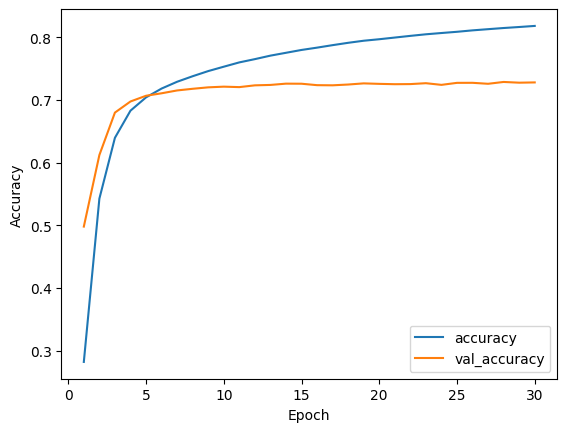

In [35]:
acc=history.history['masked_accuracy']
val_acc=history.history['val_masked_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## 5. Evaluation

Tekst

## 6. Deployment

Tekst